## Multi-label prediction with Planet Amazon dataset

In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

## Getting the data

In [ ]:
# ! pip install kaggle --upgrade

In [ ]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [4]:
Config.data_path()

PosixPath('/home/jupyter/.fastai/data')

In [12]:
!ls -a /home/jupyter/.fastai/data/

.   dogscats	  mnist_sample	    oxford-iiit-pet
..  dogscats.tgz  mnist_sample.tgz  oxford-iiit-pet.tgz


In [3]:
# Create a directory for planet data
path = Config.data_path() / 'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [16]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

 96%|██████████████████████████████████████▍ | 577M/600M [00:05<00:00, 89.1MB/s]
100%|█████████████████████████████████████████| 600M/600M [00:05<00:00, 114MB/s]
  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 73.7MB/s]


In [19]:
# !unzip -q -n {path} / 'train_v2.csv.zip' -d {path}

unzip:  cannot find or open /home/jupyter/.fastai/data/planet, /home/jupyter/.fastai/data/planet.zip or /home/jupyter/.fastai/data/planet.ZIP.


In [ ]:
# ! conda install -y -c haasad eidl7zip
# !7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
df.tags.unique()

array(['haze primary', 'agriculture clear primary water', 'clear primary', 'agriculture clear habitation primary road',
       ..., 'artisinal_mine bare_ground clear habitation road',
       'agriculture cultivation cultivation partly_cloudy primary water',
       'bare_ground clear cultivation primary road selective_logging',
       'agriculture partly_cloudy primary road conventional_mine'], dtype=object)

In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1,
                      max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [7]:
# Get the labels from the the CSV file
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [17]:
data.classes

['primary',
 'road',
 'cultivation',
 'blooming',
 'selective_logging',
 'haze',
 'bare_ground',
 'habitation',
 'water',
 'agriculture',
 'cloudy',
 'artisinal_mine',
 'blow_down',
 'conventional_mine',
 'slash_burn',
 'partly_cloudy',
 'clear']

In [18]:
len(data.train_ds), len(data.valid_ds)

(32384, 8095)

In [19]:
data.c

17

`show_batch` still works, and show us the different labels separated by `;`.

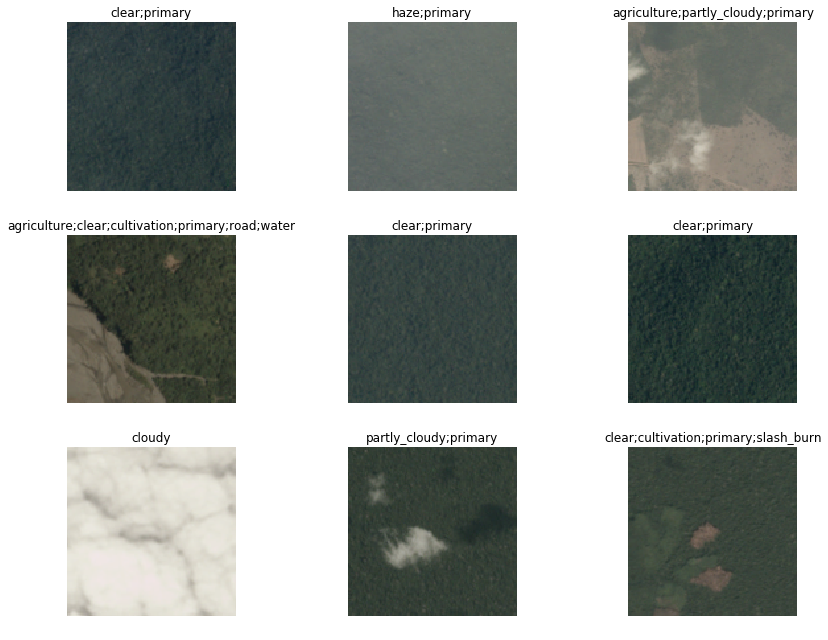

In [9]:
data.show_batch(rows=3, figsize=(12,9))

The default threshold used in accuracy is 0.5 --> Any probability that is. >= 0.5 will be classified as poisitive class. For f-score, if beta > 1 --> favors recall over precision. If beta < 1, we favor precision over recall. 

In [10]:
# Modify metrics with threshold
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [14]:
# Create CNN
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


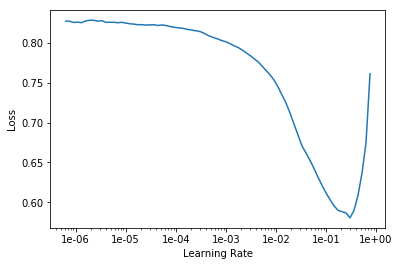

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr = 0.01
learn.fit_one_cycle(5, max_lr=slice(lr))

Total time: 09:11
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.114618    0.102342    0.949402         0.913143  (01:50)
2      0.112819    0.101999    0.950935         0.905795  (01:48)
3      0.101469    0.093148    0.950485         0.918132  (01:49)
4      0.095066    0.086759    0.958159         0.925006  (01:50)
5      0.089675    0.085063    0.957665         0.926103  (01:51)



In [27]:
!ls {path / 'train-jpg/train_0.jpg'}

/home/jupyter/.fastai/data/planet/train-jpg/train_0.jpg


In [29]:
img = open_image('/home/jupyter/.fastai/data/planet/train-jpg/train_0.jpg')

In [34]:
learn.predict(img).size()

torch.Size([1, 17])

In [35]:
learn.save('planet-128-resnet50-feature-extraction')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


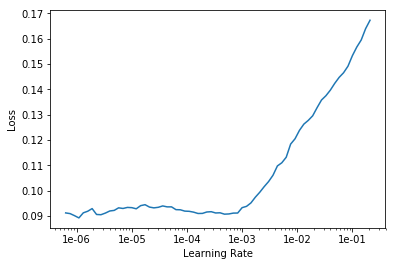

In [36]:
# Unfreeze and fine tune
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [37]:
data.train_ds[0]

(Image (3, 128, 128), MultiCategory haze;primary)

In [38]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

Total time: 12:04
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.099590    0.094906    0.955310         0.916600  (02:21)
2      0.098742    0.091677    0.953733         0.921576  (02:24)
3      0.095096    0.086451    0.953239         0.925816  (02:25)
4      0.087327    0.083775    0.958762         0.928588  (02:26)
5      0.086657    0.082369    0.959132         0.929954  (02:26)



In [35]:
learn.save('planet-128-resnet50-fine-tuned')

In [45]:
data.train_dl.batch_size

64

In [9]:
# Retrain using bigger image size
data = (src.transform(tfms, size=256)
        .databunch(bs=32).normalize(imagenet_stats))

data.train_ds[0][0].shape, data.train_dl.batch_size

(torch.Size([3, 256, 256]), 32)

In [12]:
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])
learn.load('planet-128-resnet50-fine-tuned')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: .
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/jupyter/.fastai/data/planet;
Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: .
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/jupyter/.fastai/data/planet;
Test: None, model=Sequential(
  (0): Sequential(
    (0):

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


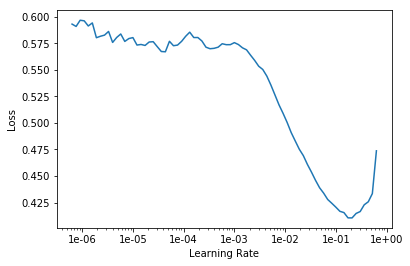

In [13]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [14]:
lr=1e-2/2

In [15]:
learn.fit_one_cycle(5, slice(lr))

Total time: 33:24
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.099165    0.089290    0.955121         0.922450  (06:39)
2      0.099942    0.086601    0.956422         0.925906  (06:40)
3      0.095689    0.086021    0.955230         0.923595  (06:41)
4      0.088591    0.084384    0.959118         0.927410  (06:41)
5      0.084485    0.082672    0.958900         0.928765  (06:41)



In [16]:
learn.save('planet-256-resnet50-feature-extraction')

In [18]:
defaults.device

device(type='cuda')

In [17]:
torch.cuda.is_available()

True

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 18:23
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.083591    0.082895    0.968310         0.928210  (03:41)
2      0.088286    0.083184    0.967424         0.928812  (03:40)
3      0.083495    0.083084    0.967998         0.929224  (03:40)
4      0.080143    0.081338    0.968564         0.931363  (03:40)
5      0.074927    0.080691    0.968819         0.931414  (03:41)



In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99%|███████████████████████████████████████▋| 599M/603M [00:11<00:00, 88.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:11<00:00, 53.2MB/s]


In [ ]:
learn.load('stage-2-256-rn50')

In [ ]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))